# NNV with SQL

Having experimented with existing verification tools, we not resort SQL to
verify neural networks. The techniques used are based on the [geometric
representation](./3.3%20Integral%20-%20Geometric%20representation.ipynb),
meaning the same constraints apply (ReLU-FNN with only 1 input, output, and
hidden layer).

## The model

We use a model with 1 input node and 1 output node that is trained on the sine
function, with a training set ranging from $-2\pi$ to $2\pi$.

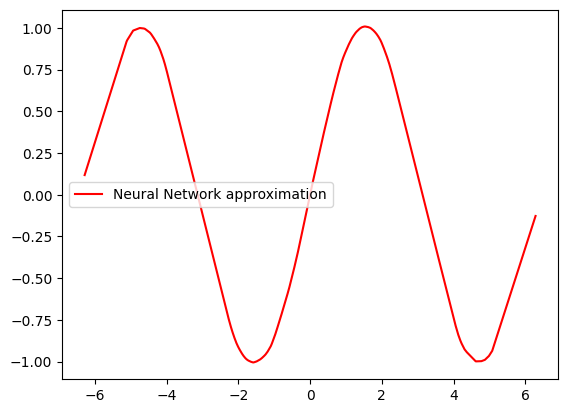

In [ ]:
import torch
import utils.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import math
import utils.duckdb as db

model = nn.ReLUFNN(input_size=1, output_size=1, hidden_size=1000, num_hidden_layers=1)
# If this file does not exist, run the preparation notebook of the mnist-showcase-app.
model.load_state_dict(torch.load("../mnist-showcase-app/models/pwl_geometric_sine.pt", weights_only=True))
model.eval()

db.load_pytorch_model_into_db(model)

x_train = np.linspace(-2 * math.pi, 2 * math.pi, 10000)
y_train = np.array([math.sin(x) for x in x_train])

with torch.no_grad():
    predicted = (
        model(torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)).detach().numpy()
    )

fig, ax = plt.subplots()
ax.plot(x_train, predicted, "r", label="Neural Network approximation")
ax.legend()
plt.show(fig)

We can see that the model approximates a sine function -- at least, on the range
we trained on. Purely informational, here it is with the x-range a bit bigger.

In [1]:
x_train = np.linspace(-10, 10, 10000)

with torch.no_grad():
    predicted = (
        model(torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)).detach().numpy()
    )

fig, ax = plt.subplots()
ax.plot(x_train, predicted, "r", label="Neural Network approximation")
ax.legend()
plt.show(fig)

NameError: name 'np' is not defined

## Correctness properties

We want to formally verify some properties of this model. Correctness properties
are defined as follows (see 
[https://arxiv.org/abs/2109.10317](https://arxiv.org/abs/2109.10317) for more
details):

$$ \begin{gather} \{ precondition \} \\
r \leftarrow f(x) \\
... \\
\{ postcondition \} \\
\end{gather}
$$

Let's give two examples, and then see if we can verify them using SQL.

**Example 1: Boundedness**. For inputs in range $[-2\pi,2\pi]$, the model's
output should always be between -1 and 1.


$$
\begin{gather}
\{ x \geq -2\pi \land x \leq 2\pi \} \\
r \leftarrow f(x) \\
\{ r \geq -1 \land r \leq 1 \}
\end{gather}
$$

**Example 2: Monotonicity**. Between [-1, 1], the function should always be
increasing.

$$
\begin{gather}
\{ x \geq -1 \land x \leq 1 \land x' \geq -1 \land x' \leq 1 \land x > x' \} \\
r \leftarrow f(x) \\
r' \leftarrow f(x') \\
\{ r \geq r' \}
\end{gather}
$$

## Example 1: Boundedness

Boundedness is actually slightly harder to verify in SQL than monotonicity. The
idea is that we calculate all breakpoints and slopes to know if any value
exceeds the given bounds.

```sql
-- The following CTEs are identical to the geometrical representation query.
WITH input_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (SELECT dst FROM edge)
),
output_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (SELECT src FROM edge)
),
hidden_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (
        SELECT * FROM input_nodes
        UNION
        SELECT * FROM output_nodes
    )
),
breakpoint_values AS (
    SELECT
        (-n.bias) / e.weight AS break_x,
    FROM node n
    JOIN edge e ON e.dst = n.id
    JOIN input_nodes i ON e.src = i.id
    JOIN hidden_nodes h ON h.id = n.id
    WHERE e.weight <> 0
    GROUP BY break_x, n.id
    ORDER BY break_x
),
breakpoints_unordered AS (
    (SELECT break_x FROM breakpoint_values)
    UNION
    (SELECT MIN(break_x) - 100.0 AS break_x FROM breakpoint_values)
    UNION
    (SELECT MAX(break_x) + 100.0 AS break_x FROM breakpoint_values)
),
breakpoints AS (
    SELECT
        break_x,
        ROW_NUMBER() OVER (ORDER BY break_x) AS row_number
    FROM breakpoints_unordered
),

input_values AS (
    SELECT break_x AS input_value FROM breakpoints
),
t1 AS (
    SELECT
        v.input_value,
        GREATEST(
            0,
            n.bias + SUM(e.weight * v.input_value)
        ) AS t1,
        e.dst AS id
    FROM edge e
    JOIN input_nodes i ON i.id = e.src
    JOIN node n ON e.dst = n.id
    CROSS JOIN input_values v
    GROUP BY v.input_value, e.dst, n.bias
),
output_values AS (
    SELECT
        t1.input_value,
        n.bias + SUM(e.weight * t1.t1) AS output_value,
        e.dst AS output_node_id
    FROM edge e
    JOIN t1 ON t1.id = e.src
    JOIN node n ON e.dst = n.id
    GROUP BY t1.input_value, e.dst, n.bias
),
breakpoint_pairs AS (
    SELECT
        u1.break_x AS u1_break_x,
        u2.break_x AS u2_break_x,
        e1.output_value AS u1_break_y,
        e2.output_value AS u2_break_y
    FROM breakpoints u1
    JOIN breakpoints u2 ON u1.row_number = u2.row_number - 1
    JOIN output_values e1 ON u1.break_x = e1.input_value
    JOIN output_values e2 ON u2.break_x = e2.input_value
),
points_and_slopes AS (
    SELECT
        u1_break_x AS x,
        u1_break_y AS y,
        (u2_break_y - u1_break_y) / (u2_break_x - u1_break_x) AS slope
    FROM breakpoint_pairs
),
-- This is where we deviate from the geometric representation query.
all_points_in_range AS (
    SELECT x, y FROM points_and_slopes 
    WHERE x >= -6.28 AND x <= 6.28

    UNION ALL

    -- Lower bound of the input range.
    SELECT -1, (-1 - x) * slope + y AS y
    FROM points_and_slopes
    WHERE x = (SELECT MAX(x) FROM points_and_slopes WHERE x < -1)

    UNION ALL

    -- Upper bound of the input range.
    SELECT 1, (1 - x) * slope + y AS y
    FROM points_and_slopes
    WHERE x = (SELECT MIN(x) FROM points_and_slopes WHERE x > 1)
)
SELECT NOT EXISTS(
    SELECT 1
    FROM all_points
    WHERE x > -1 AND x < 1
    AND (y < -1 OR y > 1)
) AS 'Boundedness property holds';
```

Let's break things down. All CTEs up to and including `points_and_slopes` are
identical to the geometric representation query, so we won't go into detail
here. 

In the next CTE, `all_points_in_range`, we collect all breakpoints (x- and y-
coordinates), within the input range, but also include two artificial points:

- The (x,y)-coordinate where x is the lower bound of the input range.
- The (x,y)-coordinate where x is the upper bound of the input range.

To calculate the y-value of the lower bound, we search for the breakpoint
closest to it from the left side. With this breakpoint being $(x_b, y_b)$, the
corresponding slope $s$, and the lower bound being $x_l$, we can use the formula 
$y = ax + b$ to find the y-value of the lower bound:

$$
y_l = (x_l - x_b) * s + y_b
$$

The y-value for the upper bound is calculated similarly. 

```sql
all_points AS (
    -- These are our regular breakpoints.
    SELECT x, y FROM points_and_slopes

    UNION ALL

    -- Lower bound of the input range.
    SELECT -6.28, (-6.28 - x) * slope + y AS y
    FROM points_and_slopes
    WHERE x = (SELECT MAX(x) FROM points_and_slopes WHERE x < -6.28)

    UNION ALL

    -- Upper bound of the input range.
    SELECT 6.28, (6.28 - x) * slope + y AS y
    FROM points_and_slopes
    WHERE x = (SELECT MIN(x) FROM points_and_slopes WHERE x > 6.28)
)
```

As the last part of the query, we check if any points within
`all_points_in_range` fall outside the bounds [-1, 1]. If there are any, we
found a counterexample and the correctness property does not hold, which is why
we check for a `NOT EXISTS`.

```sql
SELECT NOT EXISTS(
    SELECT 1
    FROM all_points_in_range
    WHERE x > -1 AND x < 1
    AND (y < -1 OR y > 1)
) AS 'Boundedness property holds';
```

Executing the query on our sine model yields the following ([full
query](./queries/verify_boundedness.sql)):

In [ ]:
with open('queries/verify_boundedness.sql') as file:
    query = file.read()

db.con.sql(query)

┌────────────────────────────┐
│ Boundedness property holds │
│          boolean           │
├────────────────────────────┤
│ false                      │
└────────────────────────────┘

The boundedness property does not hold! The reason for this is that the model's
output is not a perfect sine function. At its highest point, its value is
actually 1.0078515792315825 instead of 1. Taking $\epsilon = 0.01$, we slightly
widen the allowed bounds:

In [ ]:
query = query.replace("y < -1 OR y > 1", "y < -1.01 OR y > 1.01")
db.con.sql(query)

┌────────────────────────────┐
│ Boundedness property holds │
│          boolean           │
├────────────────────────────┤
│ true                       │
└────────────────────────────┘

Now we see the boundedness property holds, as expected.

## Example 2: Monotonicity

The logic to check if the sine function is monotonically increasing for $x \in
[-1,1]$ is actually pretty easy because we have the slopes. The query looks as
follows:

```sql
WITH points_and_slopes (
    -- Identical to the geometric representation query.
)
SELECT NOT EXISTS(
    SELECT 1
    FROM points_and_slopes
    -- Closest breakpoint left of lower bound
    WHERE x >= (SELECT MAX(x)
               FROM points_and_slopes
               WHERE x < -1)
    AND x < 1
    AND slope <= 0
) AS 'Monotonicity property holds';
```

For all breakpoints within the input range *and* the first breakpoint smaller
than the lower bound, we check if the slope is positive. That's it!

Let's check this property as well ([full
query](./queries/verify_monotonicity.sql)):

In [ ]:
with open('queries/verify_monotonicity.sql') as file:
    query = file.read()

db.con.sql(query)

┌─────────────────────────────┐
│ Monotonicity property holds │
│           boolean           │
├─────────────────────────────┤
│ true                        │
└─────────────────────────────┘

The property holds. Let's increase the range to [-2, 1], for which we no longer
expect the sine function to be monotonically increasing.

In [ ]:
query = query.replace("WHERE x < -1", "WHERE x < -2")
db.con.sql(query)

┌─────────────────────────────┐
│ Monotonicity property holds │
│           boolean           │
├─────────────────────────────┤
│ false                       │
└─────────────────────────────┘

## Combining pruning and verification

In this example we'll combine a few techniques in order to show the usefulness
of treating models as data:

- Store a model in the database
- Prune it using a SQL query
- Compare the two models and formally verify some behavior

We already have the sine model in the database, so we'll use that. We will prune
the model up until the monotonicity property no longer holds.

The pruning logic is the one from
[before](./2.0%20Basic%20model%20queries.ipynb): we order the hidden nodes by
their maximum outgoing weight value, and start pruning the smallest ones.

To make things easier, we implement this functionality as a DuckDB macro:

```sql
CREATE OR REPLACE TEMP MACRO prune_and_verify(number_of_nodes_to_prune) AS TABLE
WITH original_input_node_ids AS (
    SELECT id
    FROM node
    WHERE id NOT IN (SELECT dst FROM edge)
),
original_output_node_ids AS (
    SELECT id
    FROM node
    WHERE id NOT IN (SELECT src FROM edge)
),
node_ids_to_keep AS (
    SELECT id
    FROM
    (
        SELECT
            src AS id,
            ROW_NUMBER() OVER (ORDER BY MAX(ABS(weight))) AS rownum
        FROM edge
        -- Exclude input nodes from pruning
        WHERE src NOT IN (SELECT id FROM original_input_node_ids)
        GROUP BY src
        ORDER BY MAX(ABS(weight))
    )
    -- This is a convoluted way to do a LIMIT, since dynamic LIMITs are not
    -- allowed in correlated subqueries in DuckDB (this is an issue if we use it
    -- in the WITH RECURSIVE later on).
    WHERE rownum > number_of_nodes_to_prune
),
nodes_to_keep AS (
    SELECT *
    FROM node
    WHERE id IN (SELECT id FROM node_ids_to_keep)
    OR id IN (SELECT id FROM original_input_node_ids)
    OR id IN (SELECT id FROM original_output_node_ids)
),
input_nodes AS (
    SELECT id
    FROM nodes_to_keep
    WHERE id NOT IN (SELECT dst FROM edge)
),
output_nodes AS (
    SELECT id
    FROM nodes_to_keep
    WHERE id NOT IN (SELECT src FROM edge)
),
hidden_nodes AS (
    SELECT id
    FROM nodes_to_keep
    WHERE id NOT IN
    (
        SELECT * FROM input_nodes
        UNION
        SELECT * FROM output_nodes
    )
),
breakpoint_values AS (
    SELECT
        DISTINCT (-n.bias) / e.weight AS break_x,
    FROM nodes_to_keep n
    JOIN edge e ON e.dst = n.id
    JOIN hidden_nodes h ON h.id = n.id
    WHERE e.weight <> 0
    GROUP BY break_x, n.id
    ORDER BY break_x
),
breakpoints_unordered AS (
    (SELECT break_x FROM breakpoint_values)
    UNION
    (SELECT MIN(break_x) - 100.0 AS break_x FROM breakpoint_values)
    UNION
    (SELECT MAX(break_x) + 100.0 AS break_x FROM breakpoint_values)
),
breakpoints AS (
    SELECT
        break_x,
        ROW_NUMBER() OVER (ORDER BY break_x) AS row_number
    FROM breakpoints_unordered
),
input_values AS (
    SELECT break_x AS input_value FROM breakpoints
),
t1 AS (
    SELECT
        v.input_value,
        GREATEST(
            0,
            n.bias + SUM(e.weight * v.input_value)
        ) AS t1,
        e.dst AS id
    FROM edge e
    JOIN input_nodes i ON i.id = e.src
    JOIN nodes_to_keep n ON e.dst = n.id
    CROSS JOIN input_values v
    GROUP BY v.input_value, e.dst, n.bias
),
output_values AS (
    SELECT
        t1.input_value,
        n.bias + SUM(e.weight * t1.t1) AS output_value,
        e.dst AS output_node_id
    FROM edge e
    JOIN t1 ON t1.id = e.src
    JOIN node n ON e.dst = n.id
    GROUP BY t1.input_value, e.dst, n.bias
),
breakpoint_pairs AS (
    SELECT
        u1.break_x AS u1_break_x,
        u2.break_x AS u2_break_x,
        e1.output_value AS u1_break_y,
        e2.output_value AS u2_break_y
    FROM breakpoints u1
    JOIN breakpoints u2 ON u1.row_number = u2.row_number - 1
    JOIN output_values e1 ON u1.break_x = e1.input_value
    JOIN output_values e2 ON u2.break_x = e2.input_value
),
points_and_slopes AS (
    SELECT
        u1_break_x AS x,
        u1_break_y AS y,
        (u2_break_y - u1_break_y) / (u2_break_x - u1_break_x) AS slope
    FROM breakpoint_pairs
)
SELECT NOT EXISTS (
    SELECT 1
    FROM points_and_slopes
    -- Closest breakpoint left of minimum input value
    WHERE x >= (SELECT MAX(x)
               FROM points_and_slopes
               WHERE x < -1)
    AND x < 1
    AND slope <= 0
) AS monotonic;
```

We can now do something like `SELECT * FROM prune_and_verify(100)` to check if
the monotonicity property still holds after pruning 100 nodes. E.g.:

```sql
SELECT 100 AS 'Nodes pruned', monotonic FROM prune_and_verify(100)
UNION ALL
SELECT 900 AS 'Nodes pruned', monotonic FROM prune_and_verify(900)
```

yields

```
┌──────────────┬───────────┐
│ Pruned nodes │ monotonic │
│    int32     │  boolean  │
├──────────────┼───────────┤
│          100 │ true      │
│          900 │ false     │
└──────────────┴───────────┘
```

(note that the query requires duckdb 1.2+)

We can also use `WITH RECURSIVE` to iteratively prune more and more nodes and
stop when our monotonicity property no longer holds.

```sql
WITH RECURSIVE pruned_models AS (
    SELECT
        0 AS number_of_pruned_nodes,
        (SELECT monotonic FROM prune_and_verify(number_of_pruned_nodes)) AS monotonic

    UNION ALL

    SELECT
        number_of_pruned_nodes + 100,
        (SELECT monotonic FROM prune_and_verify(number_of_pruned_nodes)) AS monotonic
    FROM pruned_models
    WHERE monotonic
)
SELECT * FROM pruned_models;
```

While this query should work, it consumes too much RAM on my humble machine to
finish in a timely manner.

## Prune & Verify with MSE

Instead of formally verifying a property, we can alternatively check if pruning
a model results in similar output values for a representative test dataset.

Let's create a representative input dataset.

In [ ]:
import random

# Insert 100 random inputs withing the test range [-6, 6]

db.con.execute("TRUNCATE input")
for i in range(0, 100):
    db.con.execute(f"""
        INSERT INTO input (input_set_id, input_node_idx, input_value)
        VALUES ({i}, 1, {random.uniform(-6, 6)})
    """)

We'll use a query similar to the `prune_and_verify` from above, but which
instead calculates the MSE compared to the unpruned network.

```sql
CREATE OR REPLACE TEMP MACRO prune_and_verify(number_of_nodes_to_prune) AS TABLE
WITH RECURSIVE input_values AS (
    SELECT input_set_id, input_node_idx, input_value FROM input
),
-- Regular eval
input_nodes AS (
    SELECT
        id,
        bias,
        ROW_NUMBER() OVER (ORDER BY id) AS input_node_idx
    FROM node
    WHERE id NOT IN (SELECT dst FROM edge)
),
output_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN (SELECT src FROM edge)
),
tx_original AS (
    SELECT
        v.input_set_id AS input_set_id,
        GREATEST(0, n.bias + SUM(e.weight * v.input_value)) AS value,
        e.dst AS id
    FROM edge e
    JOIN input_nodes i ON i.id = e.src
    JOIN node n ON e.dst = n.id
    JOIN input_values v ON i.input_node_idx = v.input_node_idx
    GROUP BY e.dst, n.bias, v.input_set_id

    UNION ALL

    SELECT
        tx.input_set_id AS input_set_id,
        GREATEST(0, n.bias + SUM(e.weight * tx.value)) AS value,
        e.dst AS id
    FROM edge e
    JOIN tx_original tx ON tx.id = e.src
    JOIN node n ON e.dst = n.id
    GROUP BY e.dst, n.bias, tx.input_set_id
),
t_out_original AS (
    SELECT
        tx.input_set_id AS input_set_id,
        n.bias + SUM(e.weight * tx.value) AS output_value,
        e.dst AS output_node_id
    FROM edge e
    JOIN output_nodes o ON e.dst = o.id
    JOIN node n ON o.id = n.id
    JOIN tx_original tx ON tx.id = e.src
    GROUP BY e.dst, n.bias, tx.input_set_id
),
-- Pruned eval
node_ids_to_keep AS (
    SELECT id
    FROM
    (
        SELECT
            src AS id,
            ROW_NUMBER() OVER (ORDER BY MAX(ABS(weight))) AS rownum
        FROM edge
        -- Exclude input nodes from pruning
        WHERE src NOT IN (SELECT id FROM input_nodes)
        GROUP BY src
        ORDER BY MAX(ABS(weight))
    )
    -- This is a convoluted way to do a LIMIT, since dynamic LIMITs are not
    -- allowed in correlated subqueries in DuckDB (this is an issue if we use it
    -- in the WITH RECURSIVE later on).
    WHERE rownum > number_of_nodes_to_prune
),
nodes_to_keep AS (
    SELECT *
    FROM node
    WHERE id IN (SELECT id FROM node_ids_to_keep)
    OR id IN (SELECT id FROM input_nodes)
    OR id IN (SELECT id FROM output_nodes)
),
tx_pruned AS (
    SELECT
        v.input_set_id AS input_set_id,
        GREATEST(0, n.bias + SUM(e.weight * v.input_value)) AS value,
        e.dst AS id
    FROM edge e
    JOIN input_nodes i ON i.id = e.src
    JOIN nodes_to_keep n ON e.dst = n.id
    JOIN input_values v ON i.input_node_idx = v.input_node_idx
    GROUP BY e.dst, n.bias, v.input_set_id

    UNION ALL

    SELECT
        tx.input_set_id AS input_set_id,
        GREATEST(0, n.bias + SUM(e.weight * tx.value)) AS value,
        e.dst AS id
    FROM edge e
    JOIN tx_pruned tx ON tx.id = e.src
    JOIN nodes_to_keep n ON e.dst = n.id
    GROUP BY e.dst, n.bias, tx.input_set_id
),
t_out_pruned AS (
    SELECT
        tx.input_set_id AS input_set_id,
        n.bias + SUM(e.weight * tx.value) AS output_value,
        e.dst AS output_node_id
    FROM edge e
    JOIN output_nodes o ON e.dst = o.id
    JOIN nodes_to_keep n ON o.id = n.id
    JOIN tx_pruned tx ON tx.id = e.src
    GROUP BY e.dst, n.bias, tx.input_set_id
),
both_output_values AS (
    SELECT
        og.input_set_id,
        og.output_node_id,
        og.output_value AS original_output_value,
        p.output_value AS pruned_output_value
    FROM t_out_original og
    JOIN t_out_pruned p ON p.input_set_id = og.input_set_id AND p.output_node_id = og.output_node_id
    ORDER BY og.input_set_id, og.output_node_id
),
MSEs AS (
    SELECT
        input_set_id,
        SUM( (original_output_value - pruned_output_value) ** 2 ) / COUNT(original_output_value) AS MSE
    FROM both_output_values
    GROUP BY input_set_id
)
SELECT AVG(MSE) as average_mse FROM MSEs;

WITH RECURSIVE prunable_node_count AS (
    SELECT COUNT(id) AS node_count
    FROM node
    WHERE EXISTS (SELECT 1 FROM edge WHERE src = id)
    AND EXISTS (SELECT 1 FROM edge WHERE dst = id)
),
pruned_models AS (
    SELECT
        0 AS number_of_pruned_nodes,
        (SELECT average_mse FROM prune_and_verify(number_of_pruned_nodes)) AS average_mse

    UNION ALL

    SELECT
        number_of_pruned_nodes + 100,
        (SELECT average_mse FROM prune_and_verify(number_of_pruned_nodes)) AS average_mse
    FROM pruned_models
    WHERE number_of_pruned_nodes + 100 < (SELECT node_count - 1 FROM prunable_node_count)
)
SELECT * FROM pruned_models;
```

In [ ]:
with open('queries/prune_and_verify_mse.sql') as f:
    query = f.read()
    db.con.execute(query)

Now we can recursively prune the network and see how the MSE evolves:

In [ ]:
query = """
WITH RECURSIVE prunable_node_count AS (
    SELECT COUNT(id) AS node_count
    FROM node
    WHERE EXISTS (SELECT 1 FROM edge WHERE src = id)
    AND EXISTS (SELECT 1 FROM edge WHERE dst = id)
),
pruned_models AS (
    SELECT
        0 AS number_of_pruned_nodes,
        (SELECT average_mse FROM prune_and_verify(number_of_pruned_nodes)) AS average_mse

    UNION ALL

    SELECT
        number_of_pruned_nodes + 100,
        (SELECT average_mse FROM prune_and_verify(number_of_pruned_nodes)) AS average_mse
    FROM pruned_models
    WHERE number_of_pruned_nodes + 100 < (SELECT node_count FROM prunable_node_count)
)
SELECT * FROM pruned_models;
"""
db.con.sql(query)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────────┬────────────────────────┐
│ number_of_pruned_nodes │      average_mse       │
│         int32          │         double         │
├────────────────────────┼────────────────────────┤
│                      0 │  2.665891488320256e-31 │
│                    100 │ 3.9048723141999456e-31 │
│                    200 │  0.0005967499068570419 │
│                    300 │   0.005703562878725251 │
│                    400 │   0.008228296399920012 │
│                    500 │   0.047494423786058074 │
│                    600 │   0.010338897151718597 │
│                    700 │    0.20047200940567564 │
│                    800 │    0.25646624072045526 │
│                    900 │     0.6155444196754705 │
├────────────────────────┴────────────────────────┤
│ 10 rows                               2 columns │
└─────────────────────────────────────────────────┘